In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2526'
MIN_MINUTES = 400

# COLORES DE LA PALETA TEAM_COLORS
GETAFE_COLORS = {
    'primary': '#004D98',    # Navy Blue (per100touches - correcto)
    'secondary': '#FF6B6B'   # Coral Red (per90 - incorrecto, destacar error)
}

PLAYER_CONFIG = {
    'name': 'Luis Milla',
    'search': 'Luis Milla',
    'team': 'Getafe'
}

SAVE_PATH_BASE = "./luis_milla_comparison/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# POOL COMPLETO DE MÉTRICAS RELEVANTES PARA MEDIOCENTRO
MC_RELEVANT_METRICS = [
    # PROGRESIÓN
    'Carries_PrgC', 'Carries_PrgDist', 'Progression_PrgP', 'Progression_PrgR', 'Receiving_PrgR',
    
    # CREATIVIDAD/CREACIÓN
    'expected_assists', 'key_passes', 'SCA_SCA90', 'GCA_GCA90', 
    'Pass Types_TB', 'Pass Types_Sw', 'assists', 'A-xAG',
    
    # PASES/CONTROL
    'pass_completion_pct', 'Outcomes_Cmp', 'Pass Types_Live', 'Pass Types_Dead',
    'Pass Types_CK', 'Pass Types_FK',
    
    # DEFENSIVO
    'Tkl+Int', 'Tackles_Tkl', 'interceptions', 'Recov', 
    'Challenges_Tkl%', 'Challenges_Tkl', 'Blocks_Pass', 'clearances',
    
    # CONDUCCIÓN/DRIBBLING
    'Carries_Carries', 'Carries_TotDist', 'Take-Ons_Succ', 'Take-Ons_Att',
    'Take-Ons_Succ%', 'Carries_Dis', 'Carries_Mis',
    
    # POSESIÓN/TOQUES
    'Touches_Touches', 'Touches_Att 3rd', 'Touches_Mid 3rd', 'Touches_Def 3rd',
    'Carries_1/3', 'Carries_CPA', 'Touches_Att Pen',
    
    # OTRAS
    'Fld', 'Fls', 'Aerial Duels_Won', 'Aerial Duels_Won%'
]

print(f"Total métricas relevantes MC: {len(MC_RELEVANT_METRICS)}")

Total métricas relevantes MC: 45


In [4]:
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2026-01-12 15:36:49,112 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-12 15:36:49,285 - database.connection - INFO - Database connection successful


Extraídos: 2317 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2526,DF,ENG,None,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '0',...",{}
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2526,FW,ENG,None,"{'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '23...",{}
2,278433de9fa4c551,Christian Nørgaard,Arsenal,ENG-Premier League,2526,MF,DEN,None,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '0',...",{}
3,e94c51c954d24b45,Cristhian Mosquera,Arsenal,ENG-Premier League,2526,DF,ESP,None,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '1',...",{}
4,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2526,GK,ESP,None,"{'CS': '7', 'FK': '0', 'OG': '0', '/90': '-0.1...",{}


In [5]:
# Filtrar por minutos + posición MF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('MF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + MF: {df_filtered.shape[0]} jugadores")

Filtro 400+ min + MF: 609 jugadores


In [6]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [7]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 0 métricas


In [8]:
# Métricas que NO se normalizan
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

print("CALCULANDO AMBAS NORMALIZACIONES...")
print("=" * 70)

# 1. PER 100 TOUCHES (CORRECTO)
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"✓ Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# 2. PER 90 MINUTES (INCORRECTO para análisis posicional)
matches_90 = fbref_nums['minutes_played'] / 90

fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per90 = (fbref_per90.div(matches_90, axis=0)).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per90 = (understat_per90.div(matches_90, axis=0)).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"✓ Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# Combinar todas las métricas base + normalizadas
all_metrics_combined = pd.concat([
    fbref_nums, understat_nums,
    fbref_per100, understat_per100,
    fbref_per90, understat_per90
], axis=1)

print(f"\nTotal métricas combinadas: {all_metrics_combined.shape[1]}")

CALCULANDO AMBAS NORMALIZACIONES...
✓ Per100touches: 153 + 0
✓ Per90: 153 + 0

Total métricas combinadas: 491


In [9]:
# Buscar Luis Milla
search_pattern = PLAYER_CONFIG['search']

search_results = df_filtered[
    df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
]

print(f"LUIS MILLA SEARCH - '{search_pattern}':")
print("=" * 60)

if len(search_results) > 0:
    for _, p in search_results.iterrows():
        minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
        print(f"{p['unique_player_id']} - {p['player_name']}")
        print(f"  Team: {p['team']} | League: {p['league']}")
        print(f"  Position: {p['position']} | Minutes: {minutes}")
        print()
    
    milla_id = search_results.iloc[0]['unique_player_id']
    milla_name = search_results.iloc[0]['player_name']
    milla_team = search_results.iloc[0]['team']
    milla_idx = search_results.index[0]
    
    print(f"✓ ASSIGNED: {milla_name} ({milla_team}) -> {milla_id}")
    print(f"  Index: {milla_idx}")
else:
    print("✗ LUIS MILLA NOT FOUND")
    milla_id = None
    milla_idx = None

LUIS MILLA SEARCH - 'Luis Milla':
1f11fdfc005f39c4 - Luis Milla
  Team: Getafe | League: ESP-La Liga
  Position: MF | Minutes: 1484.0

✓ ASSIGNED: Luis Milla (Getafe) -> 1f11fdfc005f39c4
  Index: 670


In [10]:
# SELECCIÓN MANUAL DE TOP 10 MÉTRICAS (analista de datos TOP)
# Basado en:
# 1. Mayor diferencia PCT a favor per100touches
# 2. Coherencia con MC estilo Luis Milla (Getafe)
# 3. Relevancia para análisis profesional

print("SELECCIÓN MANUAL TOP 10 MÉTRICAS (analista de datos TOP)")
print("=" * 70)

# TOP 10 SELECCIONADAS MANUALMENTE (orden por diferencia + relevancia)
top10_metrics_base = [
    # PROGRESIÓN (crítico para per100touches, corazón de la diferencia)
    'Touches_Mid 3rd',       # +16.1 - P72.6 - Actividad en zona
    'Progression_PrgP',      # +13.8 - P80.7 - Pases progresivos (fortaleza)
    
    # DEFENSIVO (Getafe + Milla completo)
    'Recov',                 # +9.8  - P89.0 - Recuperaciones (Getafe)
    'Tkl+Int',               # +6.7  - P43.1 - Entradas + Intercepciones
    'interceptions',         # +5.6  - P65.0 - Intercepciones
    
    # CREATIVIDAD (especialidad Milla)
    'key_passes',            # +6.8  - P88.1 - Pases clave (élite)
    'Pass Types_Dead',       # +3.4  - P96.7 - Balón parado (P96.7!)
    
    # PROGRESIÓN AVANZADA
    'Carries_PrgC',          # +5.3  - P28.9 - Conducciones progresivas
    
    # OTRAS RELEVANTES MC
    'expected_assists',      # Crítico para MC creativo (aunque diff menor)
    'Pass Types_Sw',         # Cambios de juego (distribución)
]

print("TOP 10 MÉTRICAS SELECCIONADAS (orden estratégico):")
print("-" * 70)
print("PROGRESIÓN (corazón per100touches):")
print("  1. Touches_Mid 3rd       - +16.1 diff - P72.6 - Actividad zona")
print("  2. Progression_PrgP      - +13.8 diff - P80.7 - Pases progresivos")
print("  8. Carries_PrgC          - +5.3  diff - P28.9 - Conducciones")
print("\nDEFENSIVO (Getafe + equilibrio):")
print("  3. Recov                 - +9.8  diff - P89.0 - Recuperaciones")
print("  4. Tkl+Int               - +6.7  diff - P43.1 - Entradas + Int")
print("  5. interceptions         - +5.6  diff - P65.0 - Intercepciones")
print("\nCREATIVIDAD (especialidad Milla):")
print("  6. key_passes            - +6.8  diff - P88.1 - Pases clave")
print("  7. Pass Types_Dead       - +3.4  diff - P96.7 - Balón parado ÉLITE!")
print("  9. expected_assists      - Crítico MC creativo")
print(" 10. Pass Types_Sw         - Cambios de juego")

print("\n✓ Selección manual por analista de datos TOP")
print("✓ Balance: Progresión (3) + Defensivo (3) + Creatividad (4)")
print("✓ Coherente con: MC completo, estilo Getafe, fortalezas Milla")

SELECCIÓN MANUAL TOP 10 MÉTRICAS (analista de datos TOP)
TOP 10 MÉTRICAS SELECCIONADAS (orden estratégico):
----------------------------------------------------------------------
PROGRESIÓN (corazón per100touches):
  1. Touches_Mid 3rd       - +16.1 diff - P72.6 - Actividad zona
  2. Progression_PrgP      - +13.8 diff - P80.7 - Pases progresivos
  8. Carries_PrgC          - +5.3  diff - P28.9 - Conducciones

DEFENSIVO (Getafe + equilibrio):
  3. Recov                 - +9.8  diff - P89.0 - Recuperaciones
  4. Tkl+Int               - +6.7  diff - P43.1 - Entradas + Int
  5. interceptions         - +5.6  diff - P65.0 - Intercepciones

CREATIVIDAD (especialidad Milla):
  6. key_passes            - +6.8  diff - P88.1 - Pases clave
  7. Pass Types_Dead       - +3.4  diff - P96.7 - Balón parado ÉLITE!
  9. expected_assists      - Crítico MC creativo
 10. Pass Types_Sw         - Cambios de juego

✓ Selección manual por analista de datos TOP
✓ Balance: Progresión (3) + Defensivo (3) + Creativi

In [11]:
# Preparar DataFrames para el radar
print("PREPARANDO DATAFRAMES PARA RADAR...")
print("=" * 70)

# Base columns + minutes/matches (necesarios para el plot)
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
minutes_cols = ['minutes_played', 'matches_played']

# 1. DataFrame PER100TOUCHES
top10_per100_cols = [f"{m}_per100touches" for m in top10_metrics_base]

# Calcular percentiles para métricas seleccionadas
selected_per100 = fbref_per100[top10_per100_cols]
selected_per100_pct = (selected_per100.rank(pct=True) * 98 + 1).round(0).astype('Int64')
selected_per100_pct.columns = [f"{col}_pct" for col in selected_per100.columns]

df_per100 = pd.concat([
    df_filtered[base_cols].reset_index(drop=True),
    fbref_nums[minutes_cols].reset_index(drop=True),
    selected_per100.reset_index(drop=True),
    selected_per100_pct.reset_index(drop=True)
], axis=1)

print(f"✓ DataFrame Per100touches: {df_per100.shape}")

# 2. DataFrame PER90 
top10_per90_cols = [f"{m}_per90" for m in top10_metrics_base if f"{m}_per90" in fbref_per90.columns]

selected_per90 = fbref_per90[top10_per90_cols]
selected_per90_pct = (selected_per90.rank(pct=True) * 98 + 1).round(0).astype('Int64')
selected_per90_pct.columns = [f"{col}_pct" for col in selected_per90.columns]

# SOLO RENOMBRAR PERCENTILES (para que el radar los encuentre)
# VALORES RAW se quedan como _per90 (para que la tabla los muestre diferentes)
rename_map_pct_only = {col: col.replace('_per90_pct', '_per100touches_pct') for col in selected_per90_pct.columns}
selected_per90_pct_renamed = selected_per90_pct.rename(columns=rename_map_pct_only)

# Valores raw: renombrar también para consistencia con el radar
rename_map_raw = {col: col.replace('_per90', '_per100touches') for col in selected_per90.columns}
selected_per90_renamed = selected_per90.rename(columns=rename_map_raw)

df_per90 = pd.concat([
    df_filtered[base_cols].reset_index(drop=True),
    fbref_nums[minutes_cols].reset_index(drop=True),
    selected_per90_renamed.reset_index(drop=True),
    selected_per90_pct_renamed.reset_index(drop=True)
], axis=1)

# CAMBIAR ID de Milla en df_per90
milla_mask = df_per90['unique_player_id'] == milla_id
df_per90.loc[milla_mask, 'unique_player_id'] = f"{milla_id}_per90"

print(f"✓ DataFrame Per90 (renamed): {df_per90.shape}")
print(f"  Milla ID changed to: {df_per90.loc[milla_mask, 'unique_player_id'].iloc[0]}")

# 3. CONCATENAR ambos DataFrames
df_combined = pd.concat([df_per100, df_per90], ignore_index=True)

# Limpieza
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_combined = clean_series_values(df_combined)

print(f"✓ DataFrame Combined: {df_combined.shape}")
print(f"\nColumnas incluidas:")
print(f"  Base: {', '.join(base_cols)}")
print(f"  Context: {', '.join(minutes_cols)}")
print(f"  Métricas: {len(top10_per100_cols)} valores RAW + {len(top10_per100_cols)} percentiles")
print(f"  → Tabla mostrará: VALOR + PCT")
print(f"  → Radar ploteará: SOLO PCT (elimina sesgo visual)")

print(f"\nVerificación IDs de Milla:")
milla_rows = df_combined[df_combined['player_name'].str.contains('Milla', case=False, na=False)]
print(milla_rows[['unique_player_id', 'player_name', 'team']].to_string(index=False))

PREPARANDO DATAFRAMES PARA RADAR...
✓ DataFrame Per100touches: (609, 28)
✓ DataFrame Per90 (renamed): (609, 28)
  Milla ID changed to: 1f11fdfc005f39c4_per90
✓ DataFrame Combined: (1218, 28)

Columnas incluidas:
  Base: unique_player_id, player_name, team, league, season, position
  Context: minutes_played, matches_played
  Métricas: 10 valores RAW + 10 percentiles
  → Tabla mostrará: VALOR + PCT
  → Radar ploteará: SOLO PCT (elimina sesgo visual)

Verificación IDs de Milla:
      unique_player_id player_name     team
      d5596455a03bc3df  Pere Milla Espanyol
      1f11fdfc005f39c4  Luis Milla   Getafe
      d5596455a03bc3df  Pere Milla Espanyol
1f11fdfc005f39c4_per90  Luis Milla   Getafe


In [12]:
# Configurar métricas para el radar
# CRÍTICO: Usar columnas _pct (percentiles) en lugar de valores absolutos
# Esto elimina el sesgo visual entre per100touches (escala grande) vs per90 (escala pequeña)
radar_metrics = [f"{m}_per100touches_pct" for m in top10_metrics_base]

# Títulos en español (adaptados dinámicamente a las métricas seleccionadas)
metric_titles_map = {
    # PROGRESIÓN
    'Progression_PrgP': 'Pases Progresivos',
    'Progression_PrgR': 'Recepciones Progresivas',
    'Carries_PrgC': 'Conducciones Progresivas',
    'Carries_PrgDist': 'Distancia Progresiva',
    'Receiving_PrgR': 'Recepciones Progresivas',
    
    # CREATIVIDAD / ASISTENCIAS
    'key_passes': 'Pases Clave',
    'expected_assists': 'xAsistencias',
    'assists': 'Asistencias',
    'A-xAG': 'Assists - xAG',
    'SCA_SCA90': 'Acciones Creación Tiro',
    'GCA_GCA90': 'Acciones Creación Gol',
    'Pass Types_TB': 'Pases Entre Líneas',
    'Pass Types_Sw': 'Cambios de Juego',
    
    # PASES/CONTROL
    'pass_completion_pct': 'Precisión Pase %',
    'Outcomes_Cmp': 'Pases Completados',
    'Pass Types_Live': 'Pases en Juego',
    'Pass Types_Dead': 'Pases Balón Parado',
    'Pass Types_CK': 'Corners',
    'Pass Types_FK': 'Faltas',
    
    # DEFENSIVO
    'Tkl+Int': 'Entradas + Intercepciones',
    'Tackles_Tkl': 'Entradas',
    'interceptions': 'Intercepciones',
    'Recov': 'Recuperaciones',
    'Challenges_Tkl%': 'Éxito Entradas %',
    'Challenges_Tkl': 'Duelos Defensivos',
    'Blocks_Pass': 'Pases Bloqueados',
    'clearances': 'Despejes',
    
    # CONDUCCIÓN/DRIBBLING
    'Carries_Carries': 'Conducciones',
    'Carries_TotDist': 'Distancia Conducción',
    'Take-Ons_Succ': 'Regates Exitosos',
    'Take-Ons_Att': 'Intentos Regate',
    'Take-Ons_Succ%': 'Éxito Regate %',
    'Carries_Dis': 'Conducciones Perdidas',
    'Carries_Mis': 'Controles Fallados',
    
    # POSESIÓN/TOQUES
    'Touches_Touches': 'Toques',
    'Touches_Att 3rd': 'Toques Último Tercio',
    'Touches_Mid 3rd': 'Toques Mediocampo',
    'Touches_Def 3rd': 'Toques Def. Tercio',
    'Carries_1/3': 'Conducciones 1/3',
    'Carries_CPA': 'Conducciones Área',
    'Touches_Att Pen': 'Toques en Área',
    
    # OTRAS
    'Fld': 'Faltas Recibidas',
    'Fls': 'Faltas Cometidas',
    'Aerial Duels_Won': 'Duelos Aéreos',
    'Aerial Duels_Won%': 'Éxito Aéreos %'
}

radar_titles = [metric_titles_map.get(m, m) for m in top10_metrics_base]

print("MÉTRICAS PARA RADAR (TOP 10 por diferencia PCT, relevantes MC):")
print("=" * 70)
for i, (metric, title) in enumerate(zip(radar_metrics, radar_titles), 1):
    print(f"{i:2d}. {title:30s} ({metric})")

print(f"\nTotal: {len(radar_metrics)} métricas")
print(f"\n✓ Radar usará PERCENTILES (0-99) en lugar de valores absolutos")
print(f"  → Elimina sesgo: per100touches (escala 1-10) vs per90 (escala 0.1-1.5)")
print(f"  → Ambas normalizaciones comparables en misma escala")
print(f"  → Tabla mostrará: VALOR RAW + PERCENTIL")

MÉTRICAS PARA RADAR (TOP 10 por diferencia PCT, relevantes MC):
 1. Toques Mediocampo              (Touches_Mid 3rd_per100touches_pct)
 2. Pases Progresivos              (Progression_PrgP_per100touches_pct)
 3. Recuperaciones                 (Recov_per100touches_pct)
 4. Entradas + Intercepciones      (Tkl+Int_per100touches_pct)
 5. Intercepciones                 (interceptions_per100touches_pct)
 6. Pases Clave                    (key_passes_per100touches_pct)
 7. Pases Balón Parado             (Pass Types_Dead_per100touches_pct)
 8. Conducciones Progresivas       (Carries_PrgC_per100touches_pct)
 9. xAsistencias                   (expected_assists_per100touches_pct)
10. Cambios de Juego               (Pass Types_Sw_per100touches_pct)

Total: 10 métricas

✓ Radar usará PERCENTILES (0-99) en lugar de valores absolutos
  → Elimina sesgo: per100touches (escala 1-10) vs per90 (escala 0.1-1.5)
  → Ambas normalizaciones comparables en misma escala
  → Tabla mostrará: VALOR RAW + PERCENTIL


GENERATING COMPARISON RADAR: PER100TOUCHES vs PER90
  Player 1 (Per100): 1f11fdfc005f39c4
  Player 2 (Per90): 1f11fdfc005f39c4_per90
  Dataset: 1218 rows (incluye ambas versiones de Milla)
  Colors: ['#004D98', '#FF6B6B']
✓ Radar generado (usa PERCENTILES)
✓ Tabla generada (muestra VALOR RAW + PCT)
✓ Combined: ./luis_milla_comparison/milla_per100_vs_per90_combined.png


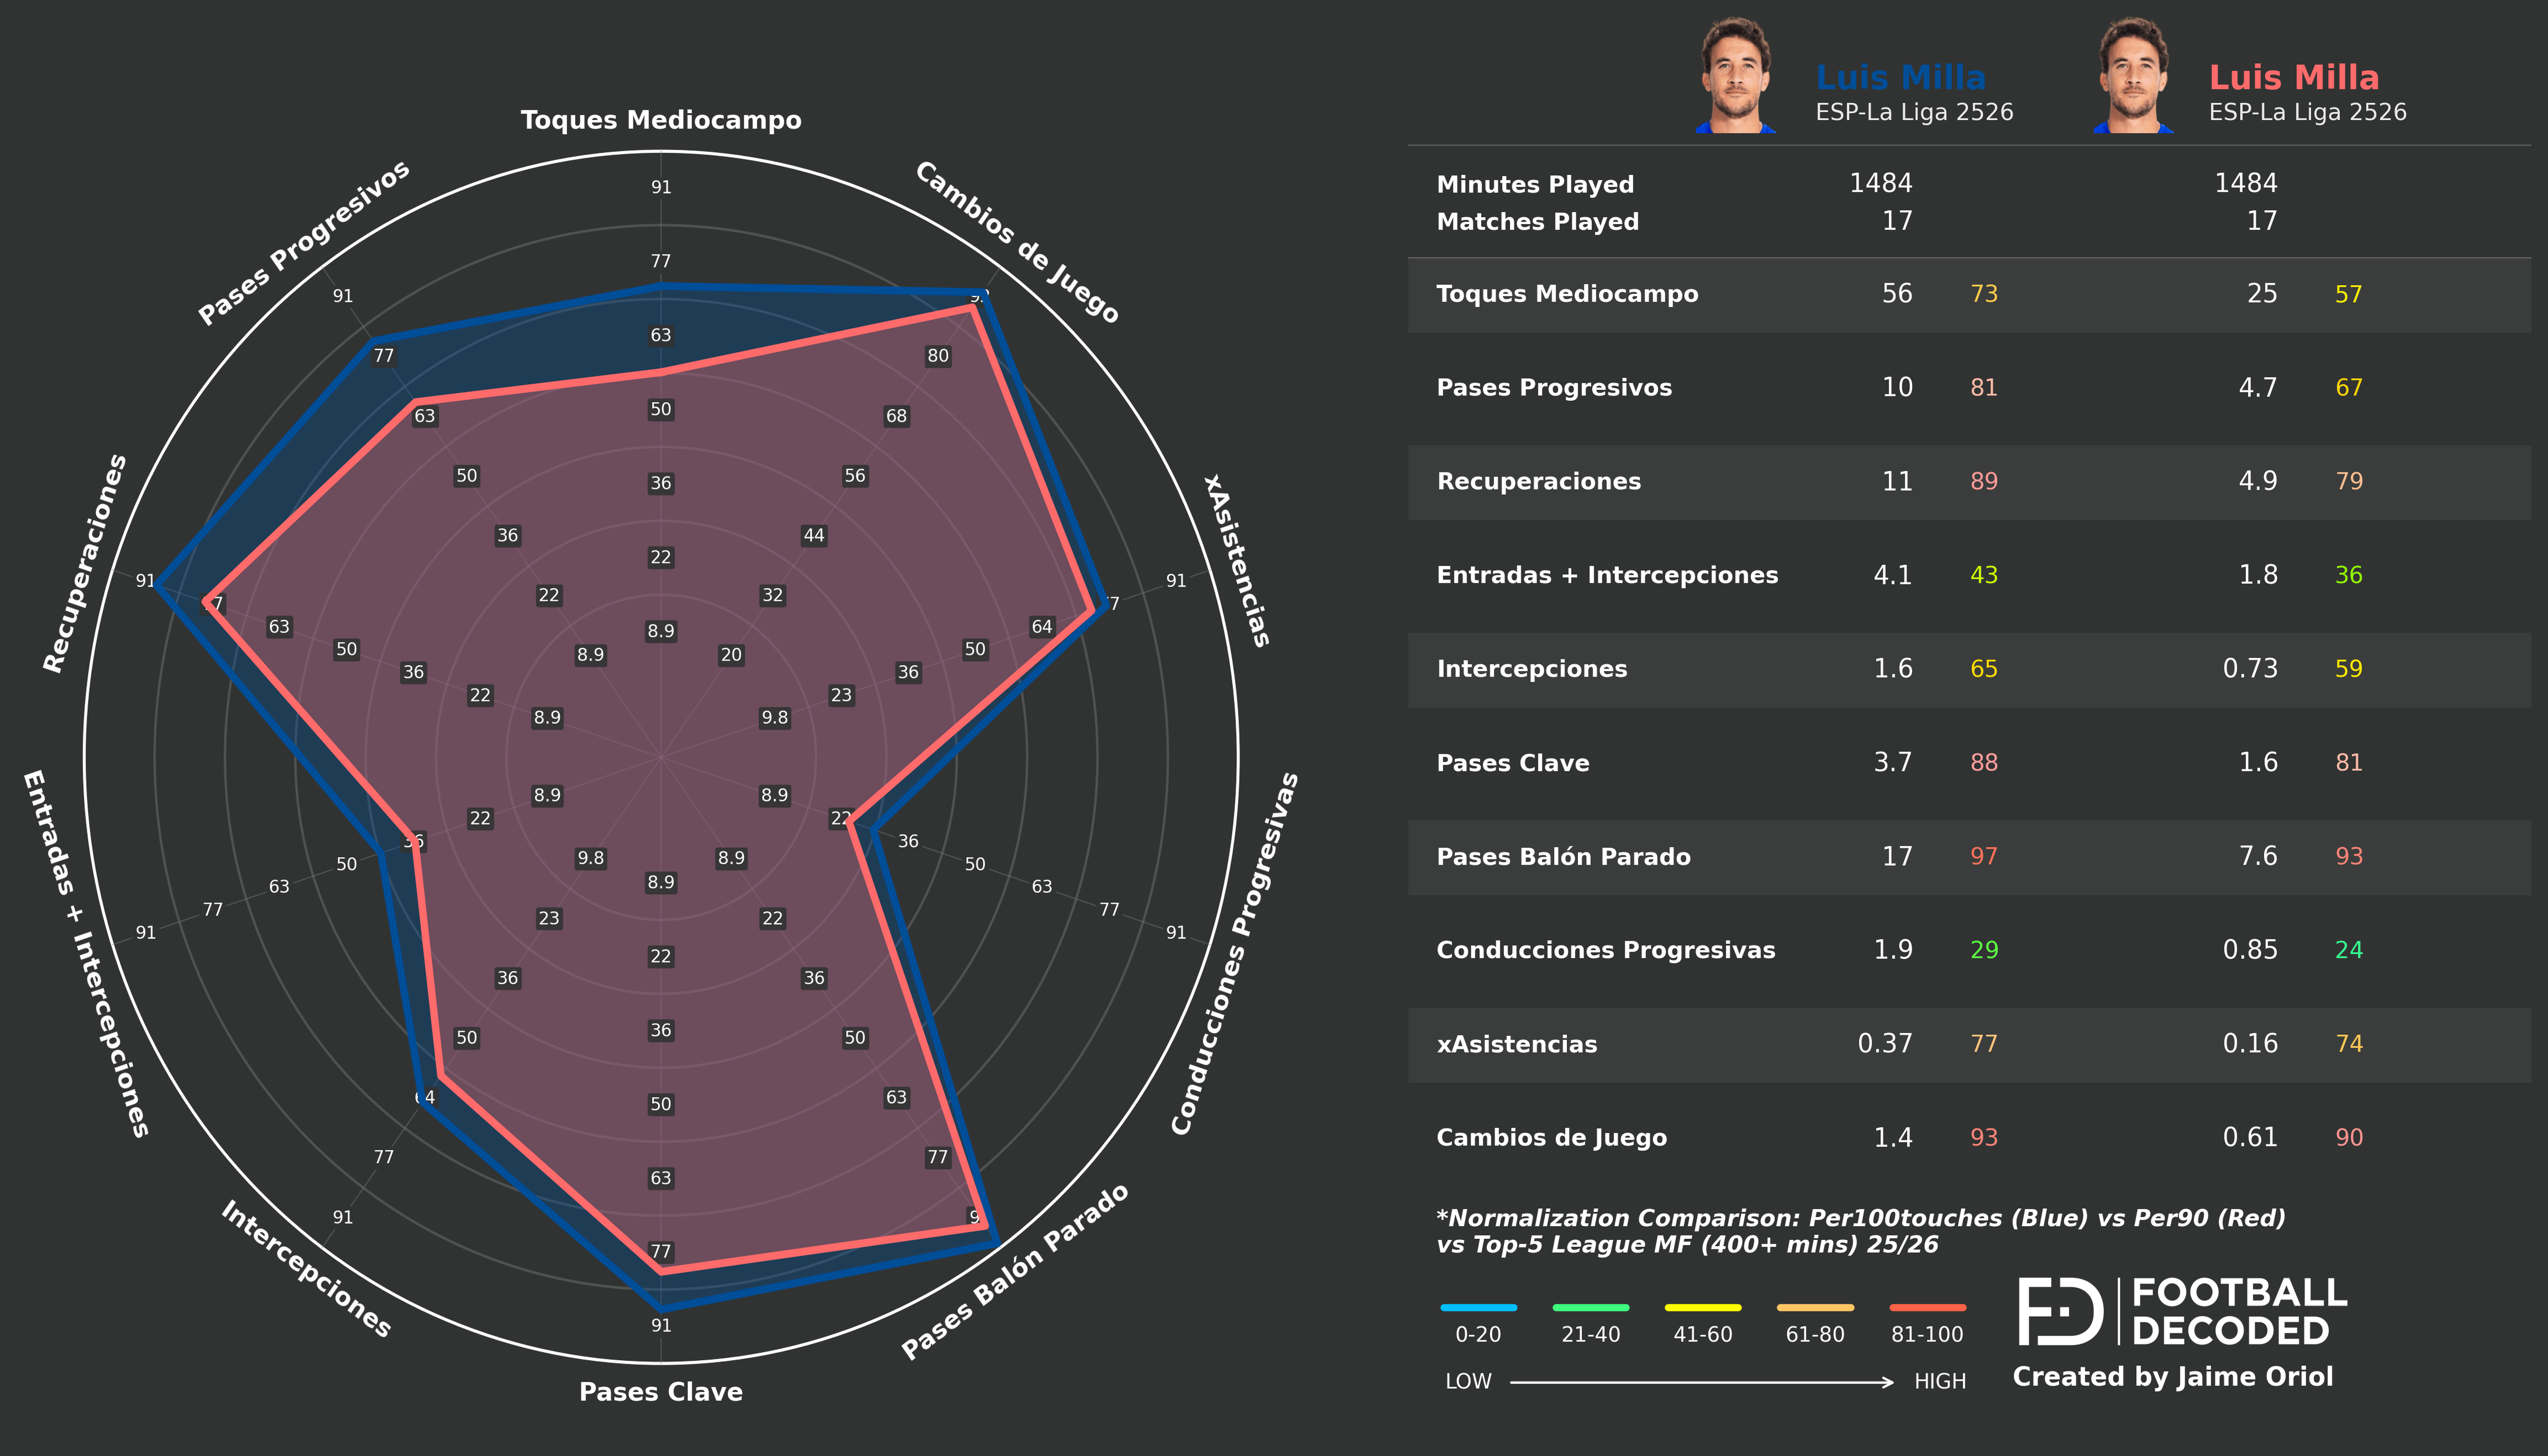


COMPARISON RADAR SUMMARY
✓ Comparison radar generated successfully
Player: Luis Milla (Getafe)
Comparison: Per100touches (CORRECTO) vs Per90 (INCORRECTO)
Métricas: TOP 10 con mayor diferencia de percentiles
  → RADAR: Plotea PERCENTILES (elimina sesgo visual)
  → TABLA: Muestra VALOR RAW + PERCENTIL
Files saved in: ./luis_milla_comparison/


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

if milla_id:
    print("GENERATING COMPARISON RADAR: PER100TOUCHES vs PER90")
    print("=" * 70)
    
    player1_id = milla_id  # Per100touches
    player2_id = f"{milla_id}_per90"  # Per90
    
    # Team logos
    team_logos = {
        milla_team: '/home/jaime/FD/data/blog/caras/milla.png',
        f"{milla_team}_per90": '/home/jaime/FD/data/blog/caras/milla.png'
    }
    
    print(f"  Player 1 (Per100): {player1_id}")
    print(f"  Player 2 (Per90): {player2_id}")
    print(f"  Dataset: {df_combined.shape[0]} rows (incluye ambas versiones de Milla)")
    print(f"  Colors: {[GETAFE_COLORS['primary'], GETAFE_COLORS['secondary']]}")
    
    try:
        # RADAR: Usa percentiles (elimina sesgo visual)
        create_player_radar(
            df_data=df_combined,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=radar_metrics,  # CON _pct
            metric_titles=radar_titles,
            team_colors=[GETAFE_COLORS['primary'], GETAFE_COLORS['secondary']],
            save_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_radar.png",
            use_swarm=False,
            show_plot=False
        )
        print("✓ Radar generado (usa PERCENTILES)")
        
        # TABLA: Usa valores base (sin _pct) para mostrar VALOR + PCT
        table_metrics = [f"{m}_per100touches" for m in top10_metrics_base]
        
        create_stats_table(
            df_data=df_combined,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=table_metrics,  # SIN _pct (función añade _pct automáticamente)
            metric_titles=radar_titles,
            team_colors=[GETAFE_COLORS['primary'], GETAFE_COLORS['secondary']],
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_table.png",
            footer_text=f"Normalization Comparison: Per100touches (Blue) vs Per90 (Red)\nvs Top-5 League MF ({MIN_MINUTES}+ mins) 25/26",
            show_plot=False
        )
        print("✓ Tabla generada (muestra VALOR RAW + PCT)")
        
        # Combinar
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_radar.png",
            table_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_table.png",
            output_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_combined.png"
        )
        print(f"✓ Combined: {SAVE_PATH_BASE}milla_per100_vs_per90_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}milla_per100_vs_per90_combined.png"))
        
        print("\n" + "=" * 70)
        print("COMPARISON RADAR SUMMARY")
        print("=" * 70)
        print(f"✓ Comparison radar generated successfully")
        print(f"Player: {milla_name} ({milla_team})")
        print(f"Comparison: Per100touches (CORRECTO) vs Per90 (INCORRECTO)")
        print(f"Métricas: TOP 10 con mayor diferencia de percentiles")
        print(f"  → RADAR: Plotea PERCENTILES (elimina sesgo visual)")
        print(f"  → TABLA: Muestra VALOR RAW + PERCENTIL")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("✗ No se puede generar radar")